#**Analyzing Different E-Commerce Customers Through Clustering**
------


>**Overview**: This dataset comes from [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data ) and [The UCI ML Repository](http://archive.ics.uci.edu/ml/index.php). The dataset pertains to actual transactions that took place between 2010 and 2011, involving a UK-based and officially registered online retail business that operates without a physical storefront. The company specializes in providing distinctive gifts suitable for various occasions. A significant portion of the company's customer base comprises of wholesale clients.
>
>The goal of this analysis was to determine characteristics that differentiated types of clients, with the intention of targeting marketing efforts towards the groups separately. While the result of this analysis was not optimal, it illustrated a real-world implementation of clustering methodologies.

#1. Import the relevant libraries and data


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

#visualization
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns

sns.set()

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



In [4]:
#Load international online transactions data from CSV
PATH = '/content/retail_data.csv'
df = pd.read_csv(PATH)

#2. Describe the data

In [5]:
#Numeric variables
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,35116.000000,35116.000000,35116.000000,33698.000000
mean,559940.650273,14.624302,4.700512,12793.819188
std,12645.318619,31.144229,51.807988,828.171434
min,536370.000000,1.000000,0.040000,12347.000000
25%,548737.000000,5.000000,1.250000,12473.000000
50%,561037.000000,10.000000,1.950000,12597.000000
75%,570672.000000,12.000000,3.750000,12708.000000
max,581587.000000,2040.000000,4161.060000,17844.000000


In [6]:
#types seem mostly correct and some nulls present in CustomerID
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35116 entries, 0 to 35115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    35116 non-null  int64  
 1   StockCode    35116 non-null  object 
 2   Description  35116 non-null  object 
 3   Quantity     35116 non-null  int64  
 4   InvoiceDate  35116 non-null  object 
 5   UnitPrice    35116 non-null  float64
 6   CustomerID   33698 non-null  float64
 7   Country      35116 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [7]:
#First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


In [8]:
#Percent of missing data by feature
round(100*df.isnull().sum()/len(df),3)

InvoiceNo      0.000
StockCode      0.000
Description    0.000
Quantity       0.000
InvoiceDate    0.000
UnitPrice      0.000
CustomerID     4.038
Country        0.000
dtype: float64

In [9]:
#Check for duplicates
duplicateRows = df[df.duplicated()]
duplicateRows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1014,538174,22326,ROUND SNACK BOXES SET OF4 WOODLAND,12,12/10/10 9:35,2.95,12471.0,Germany
1143,538826,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,12/14/10 12:58,3.75,12370.0,Cyprus
1504,539419,48138,DOORMAT UNION FLAG,10,12/17/10 14:10,6.75,12431.0,Australia
3740,541975,22452,MEASURING TAPE BABUSHKA PINK,24,1/24/11 14:24,2.95,NaN,Hong Kong
3741,541975,22454,MEASURING TAPE BABUSHKA RED,24,1/24/11 14:24,2.95,NaN,Hong Kong
...,...,...,...,...,...,...,...,...
32886,578273,22554,PLASTERS IN TIN WOODLAND ANIMALS,1,11/23/11 13:41,1.65,14335.0,Germany
33112,578488,23581,JUMBO BAG PAISLEY PARK,10,11/24/11 12:53,2.08,12784.0,Portugal
33113,578488,23203,JUMBO BAG VINTAGE DOILY,10,11/24/11 12:53,2.08,12784.0,Portugal
33268,578541,23116,VEGETABLE GARDEN CHOPPING BOARD,2,11/24/11 15:01,4.95,14277.0,France


In [10]:
#drop duplicates
df.drop_duplicates(keep='first', inplace=True)

#Given small amount of missings, we also drop where CustomerID is null
df = df[df.CustomerID.notnull()]

#3. Basic Exploration

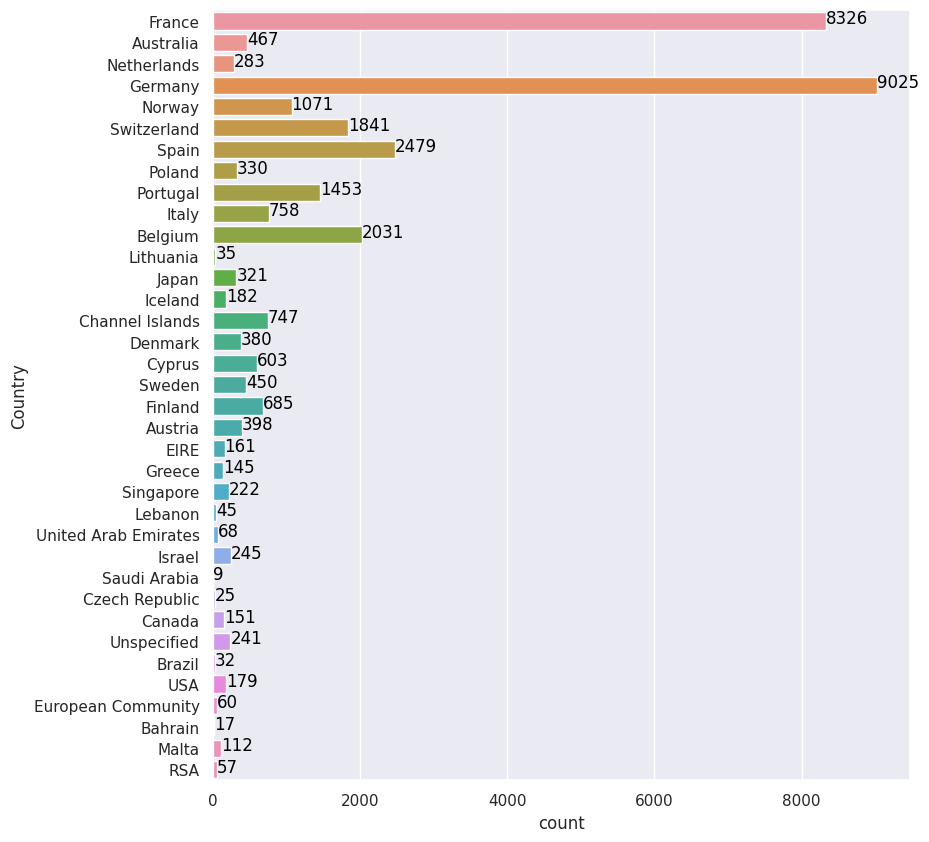

In [11]:
#Plot each country transaction quantity
plt.figure(figsize=(9,10))
ax = sns.countplot(y='Country', data=df)

for i in ax.patches:
    ax.text(i.get_width()+0.1, i.get_y()+0.5, str(round(i.get_width())), fontsize=12, color='black')

plt.show()

#France and Germany make plurality of transactions

In [12]:
#Converting customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

In [13]:
#Create 'Sales' interaction feature
df['Spent'] = df.UnitPrice * df.Quantity

df.Spent.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Spent, dtype: float64

In [14]:
#save for later analysis 
cleaned_transactions = df

In [15]:
#See # of transactions each customer made
by_customer = df.groupby('CustomerID')['InvoiceNo'].nunique().rename('total_transactions').reset_index()

by_customer.head()

,CustomerID,total_transactions
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,8


In [16]:
#See # of products each customer purchased
product_data = df.groupby('CustomerID')['StockCode'].agg(['count', 'nunique'])\
.rename(columns={'count': 'total_products', 'nunique': 'total_unique_products'}).reset_index()

product_data.head()

,CustomerID,total_products,total_unique_products
0,12347,182,103
1,12348,31,22
2,12349,73,73
3,12350,17,17
4,12352,85,59


In [17]:
#See overview by each customer
sales_data = df.groupby('CustomerID')['Spent'].agg(['sum','mean'])\
.rename(columns ={'sum':'total_sales', 'mean':'avg_product_value'}).reset_index()

sales_data.head()

,CustomerID,total_sales,avg_product_value
0,12347,4310.00,23.681319
1,12348,1797.24,57.975484
2,12349,1757.55,24.076027
3,12350,334.40,19.670588
4,12352,2506.04,29.482824


In [18]:
#Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo'])['Spent'].agg(cart_value='sum').reset_index()

cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


In [19]:
#Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID')['cart_value']\
.agg(avg_cart_value='mean', min_cart_value='min', max_cart_value='max').reset_index()

agg_cart_data.head()

,CustomerID,avg_cart_value,min_cart_value,max_cart_value
0,12347,615.714286,224.82,1294.32
1,12348,449.310000,227.44,892.80
2,12349,1757.550000,1757.55,1757.55
3,12350,334.400000,334.40,334.40
4,12352,313.255000,120.33,840.30


#4. Create data to work with later on

In [20]:
#Join together customer-level data
customer_df = by_customer.merge(product_data, on='CustomerID').merge(sales_data, on='CustomerID').merge(agg_cart_data, on='CustomerID')
customer_df.set_index(customer_df.columns[0], inplace=True)

#Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [21]:
#Create a table of customers vs stock codes purchased
item_data = pd.get_dummies(df.StockCode)
item_data['CustomerID'] = df.CustomerID
item_data = item_data.groupby('CustomerID').sum()
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


In [22]:
#Total times each item was purchased
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

In [23]:
#The most popular 20 items
item_data.sum().sort_values().tail(20)

22961      114
22630      115
22139      117
21080      122
85099B     123
20726      123
20719      128
20750      132
23084      140
20725      141
21212      143
22551      158
22629      159
22328      165
21731      169
22556      179
22554      195
22423      222
22326      270
POST      1055
dtype: int64

In [24]:
#Get list of StockCodes for the 20 most popular items
top_20_items = list(item_data.sum().sort_values().tail(20).index)

top_20_items

['22961',
 '22630',
 '22139',
 '21080',
 '85099B',
 '20726',
 '20719',
 '20750',
 '23084',
 '20725',
 '21212',
 '22551',
 '22629',
 '22328',
 '21731',
 '22556',
 '22554',
 '22423',
 '22326',
 'POST']

In [25]:
#Keep features for top 20 items
top_20_item_data = item_data[top_20_items]

#Shape of remaining dataframe
top_20_item_data.shape

(414, 20)

In [26]:
#Display item_data's shape
item_data.shape

(414, 2574)

#5. Simplify the amount of features to be more manageable

In [27]:
#Scale item data

#Initialize instance of StandardScaler
scaler = StandardScaler()

#Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

#Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [28]:
#Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

In [29]:
#Generate new features
PC_items = pca.transform(item_data_scaled)

#Display first 5 rows
PC_items[:5]

array([[ 5.84497937e+00,  4.82394648e+00, -5.79303262e-01, ...,
        -6.61212341e-04, -4.13254535e-05,  3.82679999e-15],
       [-4.22189100e+00,  1.20860769e+00, -1.91821199e+00, ...,
        -1.96102377e-04, -2.68886731e-04, -9.36750677e-17],
       [-1.24360556e+00,  2.39086835e+00, -9.03976861e-02, ...,
         2.50364512e-04, -2.03376857e-04,  2.19269047e-15],
       [-4.92432011e+00, -7.32324271e-01, -1.59276200e+00, ...,
        -1.98159802e-03,  9.49081069e-05,  3.96210842e-15],
       [-2.06213827e+00,  2.09867532e+00,  1.63485144e-01, ...,
        -3.36304676e-04, -1.32845689e-04,  5.74540415e-15]])

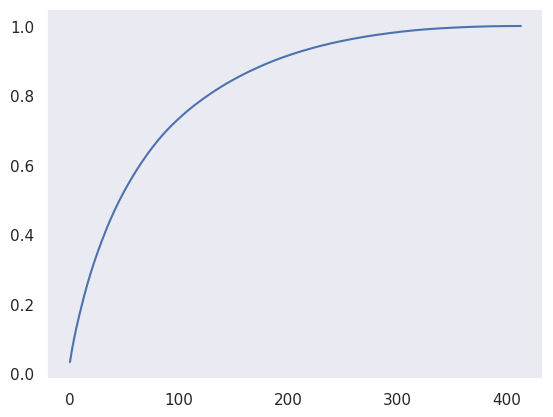

In [30]:
#Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

#Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [31]:
#How much variance we'd capture with the first 250 components
cumulative_explained_variance[250]

0.9575217624997123

In [32]:
pca = PCA(n_components=250)

#Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

#Display shape of PC_items
PC_items.shape

(414, 250)

In [33]:
#Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

#Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

#Update its index
items_pca.index = item_data.index

#Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.844979,4.823947,-0.579303,3.091230,-7.858127,8.602103,2.329192,6.923118,5.446039,4.681130,5.134093,-2.066780,12.661137,-8.809336,8.848283,5.397387,-1.606616,7.546599,-14.441455,-15.410537,-4.987130,9.868666,43.655316,-31.638870,-17.713364,10.551500,23.502842,2.113081,-28.727316,-29.103813,7.661155,13.545808,1.118167,-31.526483,0.081040,-17.868152,-11.072265,14.011056,-2.098941,5.191169,-5.392272,2.205844,-10.642913,1.682764,3.115839,4.375995,-1.720049,-4.308423,-5.720439,2.672870,...,0.276511,-0.233365,-0.040627,0.256023,0.102367,-0.373350,0.114933,0.185649,0.182224,-0.230069,-0.063794,-0.201622,-0.210053,-0.065378,0.104497,-0.214145,0.107046,0.110261,-0.239333,0.000135,-0.043191,0.104311,0.123930,0.031571,-0.016222,-0.079255,-0.326582,0.005505,-0.113096,0.033761,0.062734,-0.152702,0.112598,0.277383,-0.007884,0.036260,0.136491,0.166681,-0.417170,0.090353,0.370639,0.109055,0.034437,0.089760,0.143323,-0.043206,0.023856,0.271655,0.136754,0.284451
12348,-4.221891,1.208608,-1.918212,-0.210253,1.231740,-0.456850,-0.941502,-0.885277,0.468917,0.779579,-0.032840,1.367562,-0.761517,0.382464,0.606700,-0.460751,-0.467312,1.187053,0.399280,-0.567195,-0.059318,0.064879,0.432624,0.308881,1.246763,-0.746780,-0.206706,0.786850,-0.525019,-0.557288,1.193847,-0.385830,0.810465,-0.800107,0.423513,-0.305030,-0.181901,-0.408936,0.156718,0.471999,-0.558538,-0.704426,-1.131453,-0.092020,-0.950477,-0.003870,-0.362750,-1.096351,0.984042,0.918833,...,-7.020745,1.287383,7.399809,3.955719,-0.446517,6.586431,-1.577501,4.686145,1.634659,3.955560,-1.166339,-5.233316,0.764281,7.636575,-6.850244,-1.788566,6.995683,-0.488674,1.446079,3.502656,-6.371535,4.258350,0.489097,5.691639,1.130107,-6.103891,-0.965719,2.886521,2.744099,-6.683234,3.902243,-0.907736,1.953190,2.070939,-1.689648,1.966034,-2.631778,-3.851338,-3.815472,-0.199911,1.964898,-0.657753,1.221033,2.452442,0.437066,-1.611500,0.205033,-0.123600,1.186645,0.749515
12349,-1.243606,2.390868,-0.090398,-1.045630,-2.424982,2.823149,-0.270707,-0.175891,-0.740620,-0.362780,1.612402,-0.646834,0.144006,2.513532,-1.843021,-0.540997,-1.820287,0.493213,0.375631,0.074904,-0.436976,0.510443,-0.870000,1.714561,-1.524972,0.488244,-1.067603,0.609318,0.229438,-1.368163,0.191723,0.771221,0.143345,-0.289256,-0.438671,-1.518393,0.771318,1.547784,-0.093431,-1.035594,-0.320918,0.251985,0.054485,0.688237,1.423347,-0.662405,0.416428,0.775710,0.476264,1.115288,...,-3.092081,0.051474,1.410211,-0.977626,-0.788916,-0.869498,1.444802,1.017416,0.223546,-2.933696,2.710654,-0.293896,0.132836,2.710344,1.490633,-0.256617,0.676088,-1.705580,-1.075364,-0.577359,1.609677,0.061117,0.477271,-0.894461,0.565616,-0.834749,-1.716415,0.054911,0.052300,-1.844341,0.898231,-0.295812,-0.791355,-0.278834,-0.073948,0.586765,-0.632067,0.529309,0.506255,1.497354,-0.171751,-0.107051,-0.665428,-1.122230,0.417798,0.002227,-0.027586,-0.060066,-0.003243,-0.483739
12350,-4.924320,-0.732325,-1.592762,-0.504651,0.186887,-0.723824,0.211005,-1.347740,1.399989,-1.219394,0.243720,1.190453,-0.172053,-0.617403,1.481671,-0.027322,0.308966,1.936641,-0.138105,0.543901,-0.184569,0.962413,1.348163,0.252340,-0.211931,-0.279762,-0.770677,1.003382,-0.334942,-0.381357,0.066441,0.474778,-1.473273,0.028159,-0.369128,-0.502239,-1.281911,-0.168546,0.555516,-0.403618,0.511963,0.074904,-0.293185,0.542770,-0.555642,-0.196975,-1.502017

In [34]:
#Print shape of each dataframe
print( customer_df.shape )
print( top_20_item_data.shape )
print( items_pca.shape )

(414, 8)
(414, 20)
(414, 250)


In [35]:
#Join customer_df with threshold item data
threshold_df = customer_df.join(top_20_item_data)

#Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [36]:
#Join base_df with pca_item_data
pca_df = customer_df.join(items_pca)

#Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.844979,4.823947,-0.579303,3.091230,-7.858127,8.602103,2.329192,6.923118,5.446039,4.681130,5.134093,-2.066780,12.661137,-8.809336,8.848283,5.397387,-1.606616,7.546599,-14.441455,-15.410537,-4.987130,9.868666,43.655316,-31.638870,-17.713364,10.551500,23.502842,2.113081,-28.727316,-29.103813,7.661155,13.545808,1.118167,-31.526483,0.081040,-17.868152,-11.072265,14.011056,-2.098941,5.191169,-5.392272,2.205844,...,0.276511,-0.233365,-0.040627,0.256023,0.102367,-0.373350,0.114933,0.185649,0.182224,-0.230069,-0.063794,-0.201622,-0.210053,-0.065378,0.104497,-0.214145,0.107046,0.110261,-0.239333,0.000135,-0.043191,0.104311,0.123930,0.031571,-0.016222,-0.079255,-0.326582,0.005505,-0.113096,0.033761,0.062734,-0.152702,0.112598,0.277383,-0.007884,0.036260,0.136491,0.166681,-0.417170,0.090353,0.370639,0.109055,0.034437,0.089760,0.143323,-0.043206,0.023856,0.271655,0.136754,0.284451
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.221891,1.208608,-1.918212,-0.210253,1.231740,-0.456850,-0.941502,-0.885277,0.468917,0.779579,-0.032840,1.367562,-0.761517,0.382464,0.606700,-0.460751,-0.467312,1.187053,0.399280,-0.567195,-0.059318,0.064879,0.432624,0.308881,1.246763,-0.746780,-0.206706,0.786850,-0.525019,-0.557288,1.193847,-0.385830,0.810465,-0.800107,0.423513,-0.305030,-0.181901,-0.408936,0.156718,0.471999,-0.558538,-0.704426,...,-7.020745,1.287383,7.399809,3.955719,-0.446517,6.586431,-1.577501,4.686145,1.634659,3.955560,-1.166339,-5.233316,0.764281,7.636575,-6.850244,-1.788566,6.995683,-0.488674,1.446079,3.502656,-6.371535,4.258350,0.489097,5.691639,1.130107,-6.103891,-0.965719,2.886521,2.744099,-6.683234,3.902243,-0.907736,1.953190,2.070939,-1.689648,1.966034,-2.631778,-3.851338,-3.815472,-0.199911,1.964898,-0.657753,1.221033,2.452442,0.437066,-1.611500,0.205033,-0.123600,1.186645,0.749515
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.243606,2.390868,-0.090398,-1.045630,-2.424982,2.823149,-0.270707,-0.175891,-0.740620,-0.362780,1.612402,-0.646834,0.144006,2.513532,-1.843021,-0.540997,-1.820287,0.493213,0.375631,0.074904,-0.436976,0.510443,-0.870000,1.714561,-1.524972,0.488244,-1.067603,0.609318,0.229438,-1.368163,0.191723,0.771221,0.143345,-0.289256,-0.438671,-1.518393,0.771318,1.547784,-0.093431,-1.035594,-0.320918,0.251985,...,-3.092081,0.051474,1.410211,-0.977626,-0.788916,-0.869498,1.444802,1.017416,0.223546,-2.933696,2.710654,-0.293896,0.132836,2.710344,1.490633,-0.256617,0.676088,-1.705580,-1.075364,-0.577359,1.609677,0.061117,0.477271,-0.894461,0.565616,-0.834749,-1.716415,0.054911,0.052300,-1.844341,0.898231,-0.295812,-0.791355,-0.278834,-0.073948,0.586765,-0.632067,0.529309,0.506255,1.497354,-0.171751,-0.107051,-0.665428,-1.122230,0.417798,0.002227,-0.027586,-0.060066,-0.003243,-0.483739
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.924320,-0.732325,-1.592762,-0.504651,0.186887,-0.723824,0.211005,-1.347740,1.399989,-1.219394,0.243720,1.190453,-0.172053,-0.617403,1.481671,-0.027322,0.308966,1.936641,-0.138105,0.543901,-0.184569,0.962413,1.348163,0.252340,-0.211931,-0.279762,-0.770677,1.003382,-0.334942,-0.381357,0.066441,0.474778,-1.473273,0.028159,-0.369128,-0.502239,-1.281911,-0.168546,0.555516,-0.4

#6. Clustering

In [37]:
#Initialize instance of StandardScaler
thres_scaler = StandardScaler()
pca_scaler = StandardScaler()

#Fit and transform
threshold_df_scaled = thres_scaler.fit_transform(threshold_df)
pca_df_scaled = pca_scaler.fit_transform(pca_df)

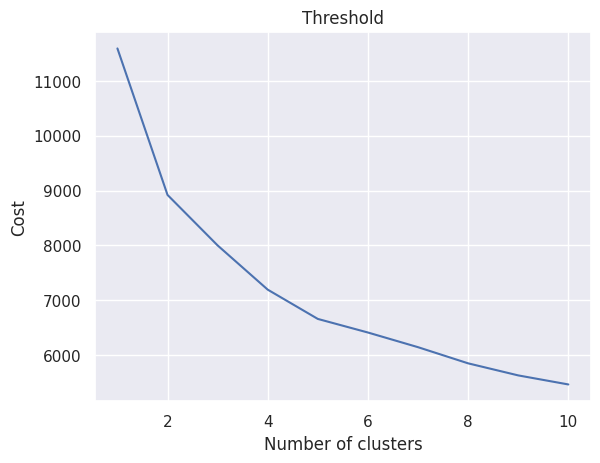

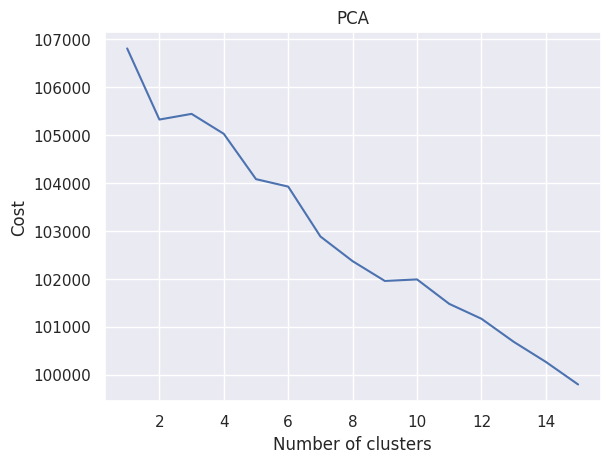

In [38]:
cost1 = []
max_clusters = 10

# Fit KMeans model and calculate the cost function for each value of k
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(threshold_df_scaled)
    cost1.append(kmeans.inertia_)

# Plot the cost function vs. the number of clusters
plt.plot(range(1,max_clusters+1),cost1)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Threshold')
plt.show()


cost2 = []
max_clusters = 15

# Fit KMeans model and calculate the cost function for each value of k
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_df_scaled)
    cost2.append(kmeans.inertia_)

# Plot the cost function vs. the number of clusters
plt.plot(range(1,max_clusters+1),cost2)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('PCA')
plt.show()

Elbow method is unclear

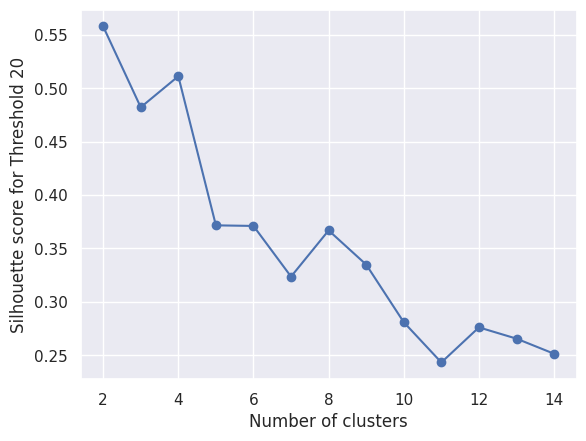

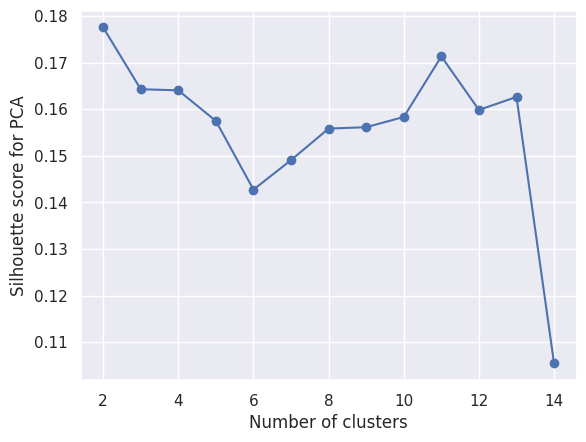

In [39]:

# Define range of number of clusters to try
range_n_clusters = range(2, 15)

# Initialize empty list to store average silhouette scores for each k
silhouette_scores = []

# Iterate over range of k
for n_clusters in range_n_clusters:
    
    # Fit KMeans clustering model
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(threshold_df_scaled)
    
    # Calculate silhouette score for the current k
    silhouette_avg = silhouette_score(threshold_df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores vs. number of clusters
import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score for Threshold 20')
plt.show()

###########

# Define range of number of clusters to try
range_n_clusters = range(2, 15)

# Initialize empty list to store average silhouette scores for each k
silhouette_scores = []

# Iterate over range of k
for n_clusters in range_n_clusters:
    
    # Fit KMeans clustering model
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(pca_df_scaled)
    
    # Calculate silhouette score for the current k
    silhouette_avg = silhouette_score(pca_df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores vs. number of clusters
import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score for PCA')
plt.show()

Looks like 2 clusters works best

In [40]:
thres_kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)

In [41]:
thres_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = thres_kmeans.fit_predict(threshold_df_scaled)

Text(0.5, 1.0, 'Threshold Clusters')

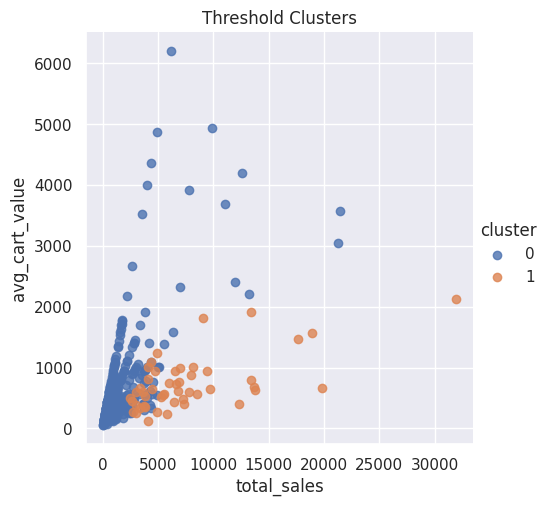

In [42]:
#Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)
plt.title('Threshold Clusters')

In [43]:
p_kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)

In [44]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

Text(0.5, 1.0, 'PCA Clusters')

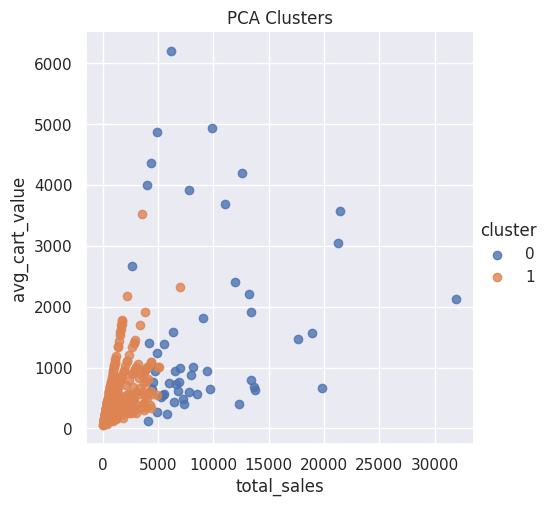

In [45]:
#Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)
plt.title('PCA Clusters')

In [46]:
#Similary between
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.5786662018059239